In [1]:
import numpy as np
import random as rnd

from qiskit import (
    QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
)
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit.circuit.controlledgate import ControlledGate 

## Introduction

Quantum computers are machines which utilise the properties of quantum mechanics to perform computations. Quantum computers are an entirely new model of computation with its own rules and mechanis. This model is believed by many to be a more powerful model than the Turing machine, which all classical computers are based on. This study introduces quantum computing to the reader, and follows with an implementation of the quantum phase estimation algorithm. At the core of this algorithm is the inverse quantum Fourier transform which executes faster than any known implementation of the Fourier transfrom on classical hardware. This provides convincing evidence (but does not prove) that the quantum computational model is superior to the Turing machine. In addition, quantum phase estimation has various known applications such as the ability to break RSA public-key cryptography - the modern day standard encryption procedure for data transferred over the internet, amongst many other things.

### Basics of Quantum Computing
#### Single Qubits and Dirac Notation
Although the classical and quantum models of computation are fundamentally different, we may draw some parallels between them. In quantum computing the respective of a bit is a qubit. A qubit is a 2d vector. In quantum physics the convention is generally to use Dirac notation to represent qubits:

\begin{equation}
\vert0\rangle =
\left [
\begin{matrix}
1 \\
0 \\
\end{matrix}
\right ]
, 
\vert1\rangle =
\left [
\begin{matrix}
0 \\
1 \\
\end{matrix}
\right ]
\tag{1}
\end{equation}

#### Systems of Multiple Qubits
The joint state of several qubits is the tensor product of their representative vectors. For example:

\begin{equation}
\vert01\rangle
 = 
\vert0\rangle\otimes\vert1\rangle
 = 
\left [ 
\begin{matrix}
1\\
0\\
\end{matrix}
\right ]
\otimes
\left [ 
\begin{matrix}
0\\
1\\
\end{matrix}
\right ]
 = 
\left [ 
\begin{matrix}
1 \left [ \begin{matrix}0\\1\\\end{matrix}\right ] \\
0 \left [ \begin{matrix}0\\1\\\end{matrix}\right ] \\
\end{matrix}
\right ]
 = 
\left [
\begin{matrix}
0\\
1\\
0\\
0\\
\end{matrix}
\right ]
\tag{2}
\end{equation}

Therefore a system of n qubits is represented by a vector of dimension $2^n$. As an example, the joint state 
$$\vert01101\rangle$$
is a system of 5 qubits and is represented by a 32 dimensional vector. We generally refer to the vector representation of qubits as a state-vector.

#### Quantum Gates
As in classical computing, we may build circuits out of gates in quantum computing. The respective of a classical gate is a quantum gate. Quantum gates are denoted by matrices. For example, a common gate is the Pauli X operator:

\begin{equation}
X =
\left [
\begin{matrix}
0 & 1 \\
1 & 0 \\
\end{matrix}
\right ]
\tag{3}
\end{equation}

An quantum gate acting on a qubit is, mathematically speaking, a matrix acting on a vector: 

\begin{equation}
X\vert0\rangle =
\left [
\begin{matrix}
0 & 1 \\
1 & 0 \\
\end{matrix}
\right ]
\left [
\begin{matrix}
1 \\
0 \\
\end{matrix}
\right ]
=
\left [
\begin{matrix}
0 \\
1 \\
\end{matrix}
\right ]
= \vert1\rangle
\tag{4}
\end{equation}

If we consider the state of the qubit before and after the application of the X gate we can see that the gate has a similar effect to a NOT gate in classical circuits: it flips the value of the qubit. There are many other gates that perform useful transformation on qubits.

Chains of gates acting on a qubit are simply successive applications of matrices to the state-vector describing the qubit. We may simplify a chain of gates by multiplying out their matrix representations; the result is a single matrix/gate performing the same linear transformation on the qubit. This property is useful for analysing quantum circuits.

#### Superposition
Qubits have a fascinating property in that they can take on a superposition of states. Consider the following operator:
$$
H =
\frac{1}{\sqrt[]{2}}
\left [
\begin{matrix}
1 & 1 \\
1 & -1 \\
\end{matrix}
\right ]
\tag{5}
$$
This is known as the Hadamard operator, H. It is a matrix that can be implemented as a quantum gate. The Hadamard operator puts qubits into a superposition of states. For example:
$$
H\vert0\rangle =
\frac{1}{\sqrt[]{2}}
\left [
\begin{matrix}
1 & 1 \\
1 & -1 \\
\end{matrix}
\right ]
\left [
\begin{matrix}
1 \\
0 \\
\end{matrix}
\right ]
=
\frac{1}{\sqrt[]{2}}
\left [\vert0\rangle + \vert1\rangle \right ]
\tag{6}
$$
The qubit seems to take on values both 1 and 0. The factor of $1/\sqrt{}{2}$ will be explained soon. This is called a superposition of states, in that both state-vector $\vert0\rangle$ and state-vector $\vert1\rangle$ are present in the state-vector describing the qubit. There are various interpretations as to what this means physically, but we do not delve into them. It is important to know, however, that according to the properties of quantum mechanics any computation applied to the qubit when in superposition is applied to the entire state-vector representing the qubit. That is,
$$
UH\vert0\rangle
= 
\frac{1}{\sqrt[]{2}}U
[\vert0\rangle + \vert1\rangle]
 = 
\frac{1}{\sqrt[]{2}}
\left [ U\vert0\rangle + U\vert1\rangle \right ]
\tag{7}
$$
for an arbitrary (unitary) matrix U. What this seems to suggest is that feeding superposed qubits into a quantum circuit causes the circuit to process every state in the superposition. It looks like this should give us tremendous computational power - it is as though we can perform huge parallel computations. For instance, consider applying Hadamard gates to each of a series of 3 qubits. The transformation is as follows: 
$$
H\vert0\rangle\otimes H\vert0\rangle\otimes H\vert0\rangle 
\\
$$
$$
=
\frac{1}{2^{-3/2}}
\left [ \vert0\rangle + \vert1\rangle \right ] \otimes
\left [ \vert0\rangle + \vert1\rangle \right ] \otimes
\left [ \vert0\rangle + \vert1\rangle \right ]
\\
$$
$$
= \frac{1}{2^{-3/2}} \left [ \vert000\rangle + \vert001\rangle + \vert010\rangle + \vert011\rangle + \vert100\rangle + \vert101\rangle + \vert110\rangle + \vert111\rangle \right ]
\tag{8}
$$
For 3 qubits we produce every permutation of 3 bits in the superposition. Having the ability to apply the same computation over all permutations of bits simultaneously would be extremely powerful. However, there is one property of quantum mechanics that forbids us from doing so, and makes taking advantage of superposition difficult. Upon measurement, a superposition "collapses" yielding only one result. For example, when measuring the three qubits that are in superposition we would yield any one, but only one, permutation at random. The catch is that we must make a measurement on a qubit to "see" its value, which immediately collapses the superposition.

Although we seem to be able to apply computations to the entire superposition, we can only measure the result of computation on one permutation. It is as if there is a "hidden space" of possibilities which, when we try to access, only presents to us the outcome of one possibility at random.

An arbitrary superposition of states may be written as
$$
\vert\psi\rangle = \sum \limits _{i} c_{i}\vert i\rangle
\tag{9}
$$
where each $\vert i\rangle$ is a bit vector (e.g. $\vert 010110\rangle$ for 6 qubits). The probability of measuring $\vert i\rangle$ is the factor $c_{i}^{2}$.

Despite the inability to extract all information from the superposition, it is possible to take advantage of the properties of qubits when superposed. The general workflow when building quantum circuits/algorithms is to set up a superposition of states and, through computation, increase the probability with which we can measure a desired state. Computer scientists, mathematicians and physicists have developed algorithms which do exactly this, and run exponentially faster than any known classical algorithm. The quantum phase estimation algorithm is one of these. It works by taking advantage of the probabilistic nature of superposition: it sets up a scenario where the most likely measurement outcome is the one that we desire.

#### Quantum Circuits
As with classical circuits, we use circuit diagrams to denote a quantum circuit. We start with an array of qubits on the left (each of which start with value 0 by convention) and use wires to connect the qubits to gates. The output of the circuit is on the right. 

As an example we have the following two qubit circuit:

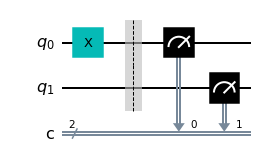

In [2]:
# Instantiate a 2 qubit circuit and 2 bit classical register.
two_qubit_circuit = QuantumCircuit(2, 2)
# Add an X operator to first qubit (index 0)
two_qubit_circuit.x(0)
# Add a barrier to separate the circuit in two (no effect on circuit)
two_qubit_circuit.barrier([0, 1])
# Add measurement operators to qubits 0 and 1
two_qubit_circuit.measure([0, 1], [0,1])

two_qubit_circuit.draw('mpl')

In the above diagram q denotes a qubit and c denotes a classical register. The rectangle with an X inside denotes an X gate and the two rectangles with a gauge inside denote measurement gates. The barrier (shaded) splits the circuit diagram into two sections (it doesn't have any function, it simply allows for a clearer explanation). The lines joining qubits and gates represent wires, like in classical circuits.
The initial joint state of the two qubits is:
$$\vert00\rangle$$
In the first half of the circuit, the first qubit (q0) is transformed by the X gate. No action is performed on the second qubit. The resulting joint state is:
$$\vert10\rangle$$
In the second half of the circuit, we apply the measurement gates. These are used to read the value of the qubits into the classical register. The classical register will therefore hold the bits [1,0]. In any useful circuit we must measure the qubits at the end of the circuit to get a result. In circuit diagrams the measurement operators are often omitted since they don't change the function of the circuit.

It should be noted that the joint state of the qubits at any point in the circuit is still the tensor product of their vector representations. We skip over the underlying maths since the result of the gate operations are more clear on a bit-wise level - an abstraction.

#### Circuits as Gates
In classical computing a circuit consisting of multiple gates can be thought of as a gate with multiple inputs and multiple outputs. Quantum circuits are very similar; a circuit consisting of multiple gates is also a gate.

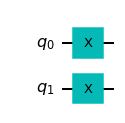

In [3]:
# Instantiate a 2 qubit circuit and 2 bit classical register.
two_qubit_circuit = QuantumCircuit(2, name='XX')
# Add an X operator to first qubit (index 0)
two_qubit_circuit.x([0,1])

two_qubit_circuit.draw('mpl')

If we only consider the bitwise operations, we can see that the circuit performs the following transformation:
$$
Circuit: \vert00\rangle\rightarrow\vert11\rangle
\tag {10}
$$
Mathematically, we can consider the X gates as linear operators acting on the respective qubit vectors. The product of each operation is a vector. We then take the tensor product of the vectors to get the joint state:
$$
X\vert0\rangle\otimes X\vert0\rangle
$$
We can rewrite this equation as
$$X\vert0\rangle\otimes X\vert0\rangle 
= (X\otimes X)(\vert0\rangle\otimes\vert0\rangle) = 
(X\otimes X)\vert00\rangle
\tag{11}
$$
What this tells us is that there exists a linear operator on both qubits that has the same effect as applying the single qubit operators as in the diagram, and that this operator is precisely
$$X\otimes X$$
This idea generalises for any group of operators. In fact, any quantum circuit acting on n qubits can be represented as a single gate acting on the joint state of those qubits. The gate has its own matrix representation. 

We can apply this idea in our code; the above circuit can be treated as a two qubit gate in a larger circuit:

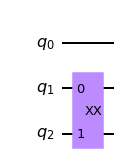

In [4]:
# Interpret the previous circuit as a gate
XX_gate = two_qubit_circuit.to_gate()
# Create a 3 qubit circuit
larger_circuit = QuantumCircuit(3)
# Add the previous circuit as a gate in the new circuit
larger_circuit.append(XX_gate, [1,2])
larger_circuit.draw('mpl')

In this three qubit circuit the gate labelled 'XX' acting on qubits q1 and q2 is the previous circuit expressed as a single gate with the transformation
$$X\otimes X$$

#### Special Gates
Finally, there exist gates with special operations on qubits. For example there are the controlled gates as shown in the example below:

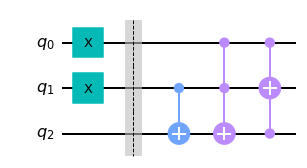

In [5]:
# Create a new circuit of 3 qubits
c_gates_example = QuantumCircuit(3)
# Prepare qubits q0 and q1 in state 1 using X gates
c_gates_example.x([0,1])
# Separate standard gates and special gates with a barrier (no effect on circuit)
c_gates_example.barrier([0,1,2])
# Add a controlled-X gate
c_gates_example.cx(1, 2)
# Add a toffoli gate (double controlled-X)
c_gates_example.toffoli(0, 1, 2)
c_gates_example.toffoli(0, 2, 1)

c_gates_example.draw('mpl')

This cicuit implements 5 gates. Prior to the barrier (shaded line) we use the standard X gates to set qubits q0 and q1 to bit value 1. After the barrier, the first "special" gate is the CX (controlled-X) gate acting on qubits q1 and q2. This gate has a target qubit (on the plus sign) and a control qubit (on the dot). It has the effect of applying the X operator to the target qubit only if the control qubit has bit value 1;
$$
CX: \vert q_{1}q_{2}\rangle\rightarrow\vert q_{1}, q_{1} \oplus q_{2}\rangle 
\tag{12}
$$
The circled plus sign indicates addition modulo 2. Substituting the values we get
$$
\vert 10\rangle\rightarrow\vert 1, 1 \oplus0\rangle = \vert11\rangle
\tag{13}
$$
The second and third gates are both double-controlled-X gates, or Toffoli gates. These gates work like the CX gate, but with two control qubits and one target qubit. Their functions are given below:
$$ Toffoli_{1}: \vert q_{1}q_{2}q_{3}\rangle\rightarrow\vert q_{1}, q_{2}, q_{3} \oplus q_{1}q_{2}\rangle 
\tag{14}
$$
$$ Toffoli_{2}: \vert q_{1}q_{2}q_{3}\rangle\rightarrow\vert q_{1}, q_{2}\oplus q_{1}q_{3}, q_{3}\rangle 
\tag{15}
$$
There are various special gates, but we will only cover those that are used in the phase estimation circuit.

#### Additional Notes on Quantum Circuits
- All quantum gates, and therefore circuits, must perform unitary transformations. A unitary transformation is a matrix which does not scale vectors. The coefficient of a state in a state-vector indicates the probability that it will be the outcome of a measurement (recall equation (9)). The sum of probabilities of all possible outcomes must be 1. If we used non-unitary tranformations, we would scale this total probability (the coefficients) to a number that is not equal to 1, which is impossible. Only unitary matrices preserve the sum of probabilities as 1.
- Qubits may take on imaginary values, but measurements always output real values. Precisely, quantum mechanical systems take place in a Hilbert space (n-dimensional complex vector space). We do not elaborate here.

## Quantum Phase Estimation
We can now implement the phase estimation circuit. The QPE (quantum phase estimation) circuit may be used to estimate eigenvalues of any unitary matrix U. We are restricted to unitary matrices because we must implement the given matrix whose eigenvalues we wish to find, in our circuit, and quantum circuits may only perform unitary tranformations.

In quantum phase estimation the dimension of U is given by $2^{v}$ (U is a square matrix) where v is the number of qubits that we use to represent an eigenvector of v. Notice that the dimension of the matrix for which we wish to find eigenvalues grows exponentially with the number of qubits we have in our circuit; we can work with very large matrices by using just a few qubits. For example, with just v=10 qubits we may find the eigenvalues of a $2^{10}$ = 1024 dimensional matrix. This hints at the ability for QPE to estimate eigenvalues with a low running time.

We also use t to denote the number of qubits that we wish to estimate the eigenvalue with. The larger this value, the larger the accuracy of estimation. 

### Generating a Random Unitary Matrix as a Gate
As mentioned, to perform phase estimation on an arbitrary unitary matrix, we must first implement that matrix as a tranformation in our quantum circuit. In this demonstration we use a function which generates a random unitary matrix implemented as a quantum circuit. This function applies a random gate operation defined by 
$$
\left [
\begin{matrix}
cos(\frac{\theta}{2}) && -e^{i\lambda}sin(\frac{\theta}{2}) \\
e^{i\phi}sin(\frac{\theta}{2}) && e^{i(\phi+\lambda)}cos(\frac{\theta}{2}) \\
\end{matrix}
\right ]
\tag{16}
$$
to each of the v qubits. The contsants $\theta$, $\phi$ and $\lambda$ are randomised for each qubit. It is not necessary to understand this transformation from a mathematical perspective. What is important is that it puts a qubit into a random state. The classical analogy is a function that performs a coin flip to determine the value of a bit. Since each of the qubits is transformed in such a way, their joint state is random. The resulting circuit is a random unitary transformation.

In our example we have v = 2 and t = 5:

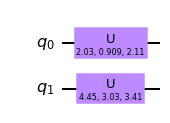

In [6]:
from qiskit.circuit.library.standard_gates import UGate

t = 5 # number of precision qubits
v = 2 # Number of qubits forming matrix dimension (dimension is 2^v) - eigenstate qubits

# Returns a circuit representation of a random unitary
def random_v_qubit_unitary(v):
    rand_u = QuantumCircuit(v)
    for i in range(v):
        theta = rnd.random() * 2 * 3.14
        phi = rnd.random() * 2 * 3.14
        lamb = rnd.random() * 2 * 3.14
        name = 'RU'
        random_gate = UGate(theta, phi, lamb)
        rand_u.append(random_gate, [i])
    return rand_u

random_unitary = random_v_qubit_unitary(v)

random_unitary.draw('mpl')

As described, we perform a a random transformation to each of the qubits. The transformation on the joint state is represented by a 4x4 matrix (since we use 2 qubits). We can show this explicitly by extracting the unitary operator describing the circuit:

In [7]:
from qiskit.quantum_info import Operator

# Get a numpy matrix representation of the unitary gate
U = np.array(Operator(random_unitary).data)
U

array([[-0.32120443+0.j        , -0.26406048+0.44208327j,
         0.40558678+0.11148723j,  0.48687398-0.46656816j],
       [-0.31631341-0.406339j  ,  0.3187769 -0.03941539j,
         0.25837417+0.62287632j, -0.41620226-0.0608746j ],
       [-0.41797795+0.04716429j, -0.27870387+0.61404908j,
        -0.31730943-0.0498699j , -0.32949586+0.39572469j],
       [-0.47127844-0.48231604j,  0.40903146-0.09809843j,
        -0.24938991-0.45052217j,  0.32103094+0.01055557j]])

### Building the Quantum Phase Estimation Circuit
The QPE circuit consists of three stages. The first performs a series of transformations (using the given unitary matrix) to set up a joint state that can be fed into the inverse quantum Fourier transform. The second stage applies the inverse quantum Fourier transform (QFT), which outputs various phases corresponding to eigenvectors of the matrix. We can calculate eigenvectors from their phase directly. The final stage consists of measuring the t precision qubits to get the output of the algorithm.

#### Stage 1: Setting up the Desired Joint State for Inverse QFT
We start with a circuit containing the appropriate number of qubits. We will measure the t precision qubits to find the eigenvalue. We must measure into a classical register, so our circuit also contains a t bit classical register.

Following, we apply Hadamard gates to each of the t precision qubits. This puts them in superposition.

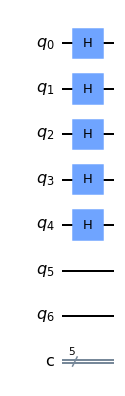

In [8]:
# Create a new circuit for phase estimation with t + v qubits.
# We will measure the precision qubits into a classical register.
# We therefore need t classical bits (denoted by c in the diagram).
phase_estimation_circuit = QuantumCircuit(t+v, t)
# Apply Hadamard transform to first t qubits
phase_estimation_circuit.h(range(t))
phase_estimation_circuit.draw('mpl')

Qubits $q_{0},...,q_{4}$ are the t precision qubits and $q_{5},...,q_{6}$ are what we call the eigenstate qubits. We follow with a series of controlled-U operations on the eigenstate qubits, where U is the unitary we created. For the ith qubit in t, we apply controlled-U $2^{t-i-1}$ times. The resulting transformation is given by
$$U^{2^{t-i-1}}$$
for each qubit in t.

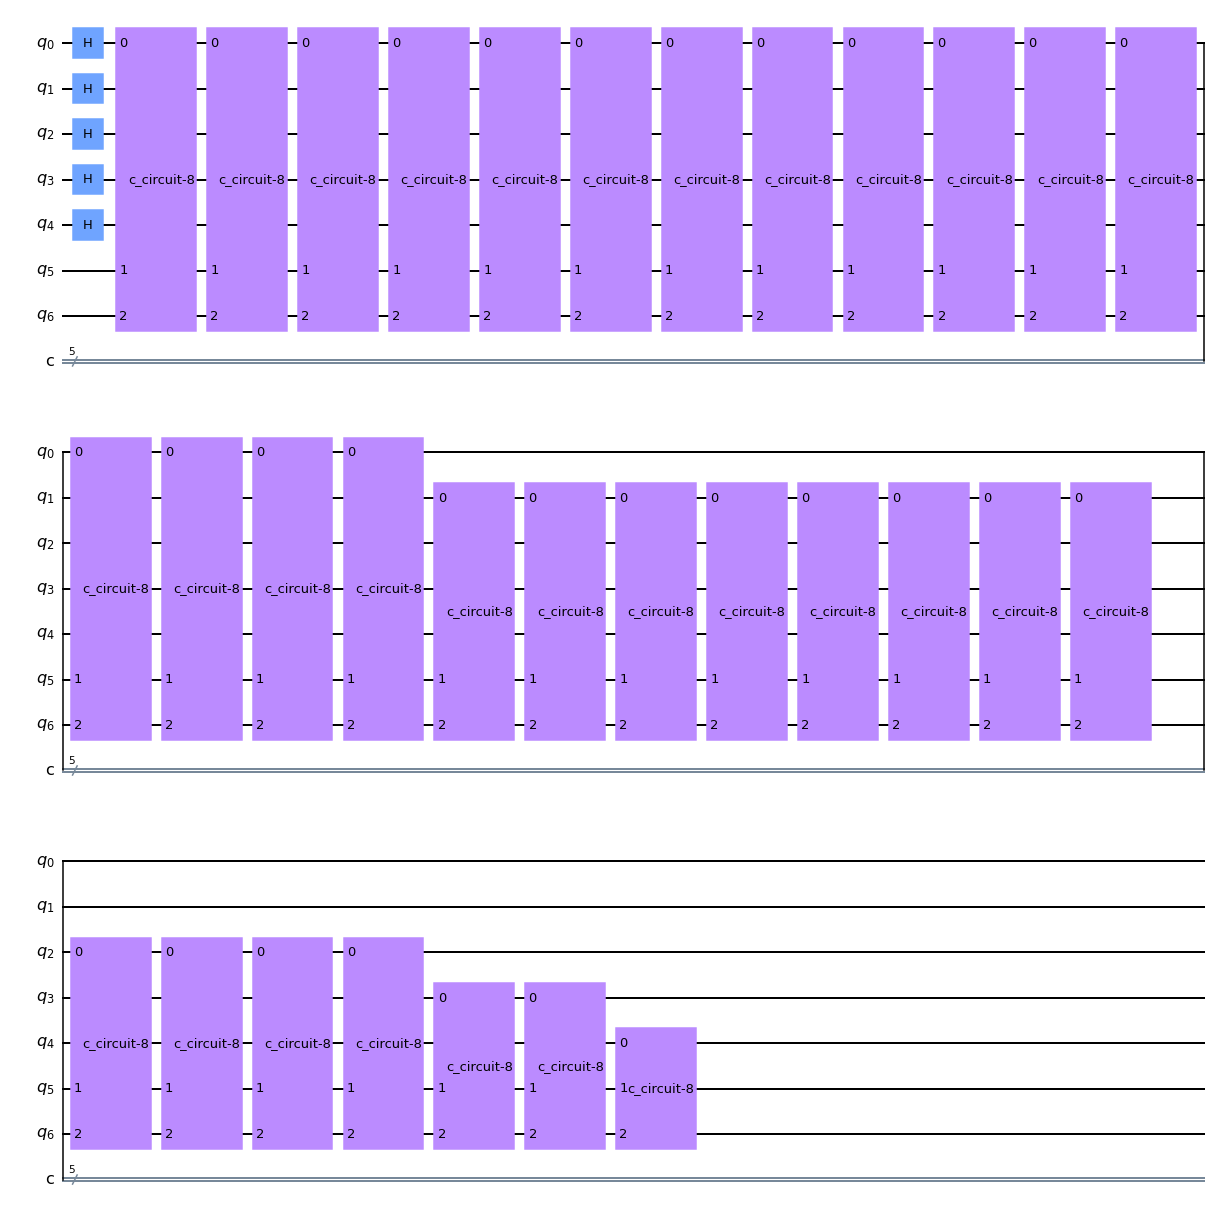

In [9]:
for i in range(t-1, -1, -1): # t-1 to 0
    for k in range(2**i): # 0 to 2^i
        """ Create an array of indices indicating which 'wires' to connect
        the unitary to in the circuit """
        qubits = [j for j in range(t-1, t+v)]
        qubits[0] = t-i-1
        # Create a single qubit controlled-U gate from the unitary.
        cru = random_unitary.control()
        # Apply the controlled-U gate to the desired wires
        phase_estimation_circuit.append(cru, qubits)

phase_estimation_circuit.draw('mpl')

#### Stage 2: Applying the Inverse Quantum Fourier Transform
The inverse quantum Fourier transform performs the transformation
$$
\frac{1}{2^{t/2}}\sum \limits _{j=0} ^{2^{t}-1} e^{2i\pi\psi j}\vert j\rangle\otimes\vert v\rangle \rightarrow \vert\hat\psi\rangle\otimes\vert v\rangle
\tag{16}
$$

- $\vert v\rangle$ is an eigenvector of U, and is can be prepared using the v eigenstate qubits in the circuit.
- $\vert\hat\psi\rangle$ is a state which, when measured, gives an estimate of $\psi$ corresponding to eigenvalue $\lambda=e^{2i\psi}$. This state is stored in the t precision qubits following application of inverse QFT.
- $e^{2i\pi\phi j}\vert j\rangle$ are, roughly speaking, a series of states (which we have prepared in the first stage of the circuit)

The first stage of the circuit effectively prepares the state to the left hand side of the arrow. There is one difference in that we did not prepare eigenvector $\vert v\rangle$ since we do not know it. Instead we have state $\vert 0...0\rangle$ prepared (using the eigenstate qubits). However, notice that the eigenvectors of matrix U form an orthonormal basis. This means we can write the state $\vert 0...0\rangle$ as a composition of U's eigenvectors:
$$
\vert 0...0\rangle = \sum \limits _{v} c_{v}\vert v\rangle
\tag{17}
$$
Applying inverse QFT in the phase estimation circuit will therefore output the joint state
$$
\sum \limits _{v} c_{v}\vert\hat\psi_{v}\rangle\otimes\vert v\rangle
\tag{18}
$$
From a quantum mechanical perspective we can interpret the t precision qubits to be in a superposition of states, each of which holds $\vert\hat\psi_{v}\rangle$ - a bit vector describing the phase of the eigenvalue corresponding to $\vert v\rangle$. Since we have a superposition, if we make a measurement of this state, we will receive a random phase of an eigenvalue of U. The probability that we measure a specific result, $\vert\hat\psi_{v}\rangle$, is proportional to $c_{v}$ (as per equation (9)). The most likely eigenvalues to be output from the circuit (following measurement) are those with the largest
$$
\vert c_{v}\vert = \langle 0...0\vert v\rangle
\tag{19}
$$
where $\langle 0...0\vert v\rangle$ is the inner product of $\vert 0...0\rangle$ and $\vert v \rangle$.

#### Stage 3: Measurement
We apply measurement gates on the t precision qubits:

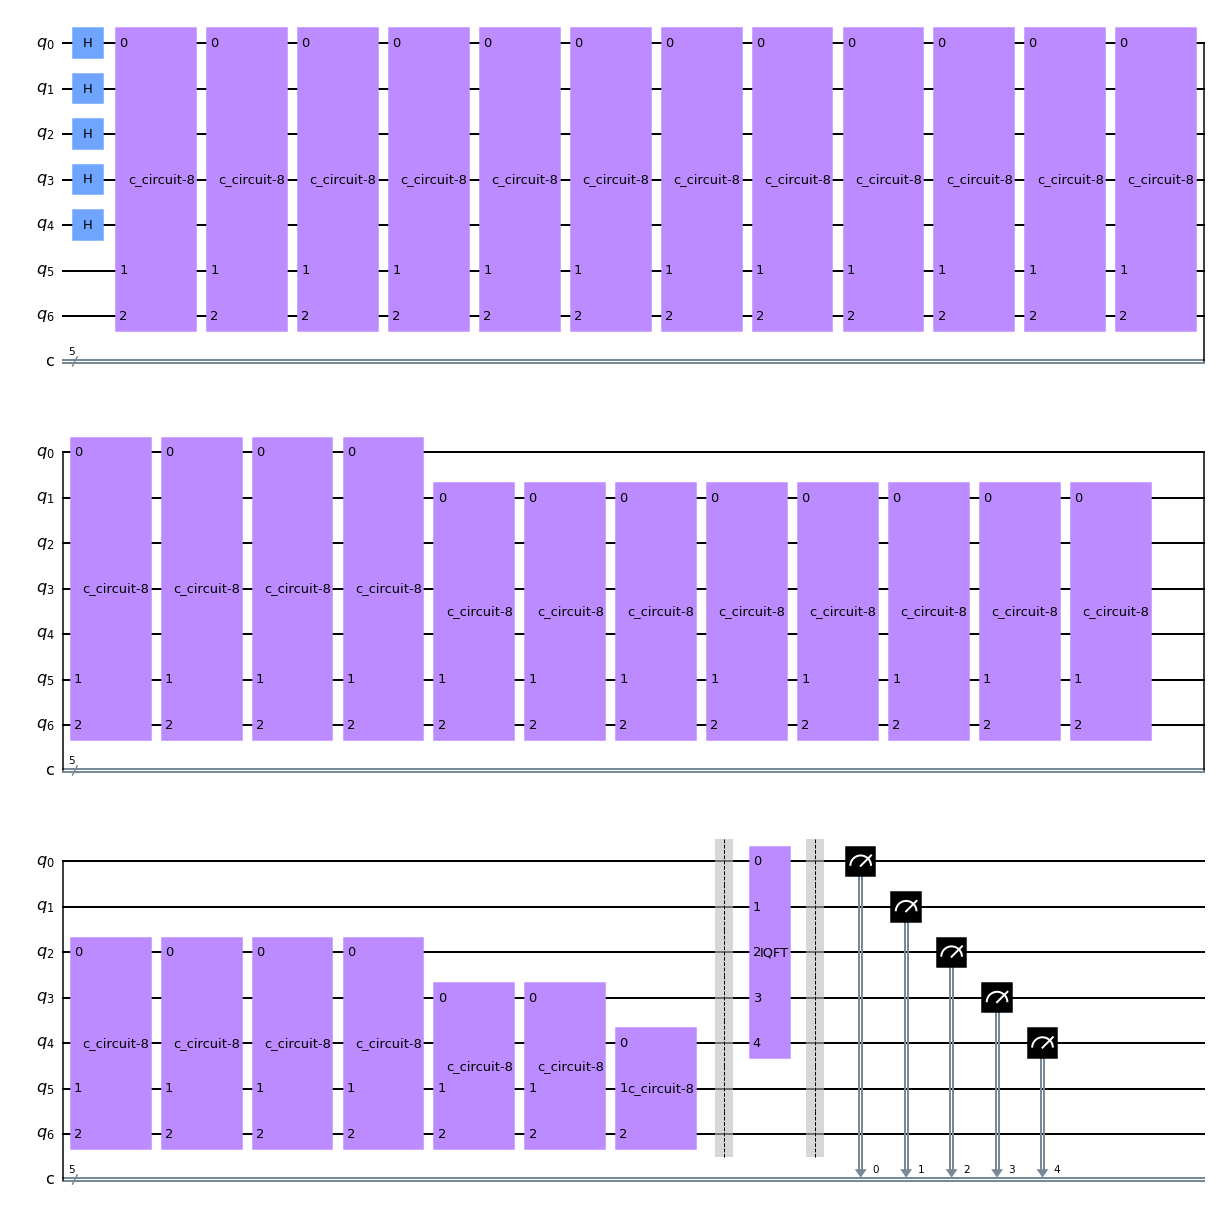

In [10]:
# Apply inverse quantum Fourier transform
phase_estimation_circuit.barrier(range(t+v))
inverse_qft = QFT(t, inverse=True)
phase_estimation_circuit.append(inverse_qft.to_gate(), range(t))
# Measure each of t qubits
phase_estimation_circuit.barrier(range(t+v))
phase_estimation_circuit.measure(range(t), range(t))

phase_estimation_circuit.draw('mpl')

## Results
We execute the circuit using a simulator. The simulator has the advantage that it can be run on any classical device, provided that the hardware is powerful enough, so we don't need quantum hardware to execute our circuit. Of course, we do not get the computational advantages of a quantum computer. We would also run into issues if we were to simulate over about 20-30 qubits on a standard machine because simulation time/space grows exponentially with the number of qubits in the simulation. Finally, the following simulation will simulate an ideal environment. In reality quantum systems are prone to noise. We would potentially have to mitigate noise by implementing error correction in our circuit. It is possible to add artificial noise into the simulator, but for the purposes of demonstration it is unnecessary. The simulation provides a proof of concept.

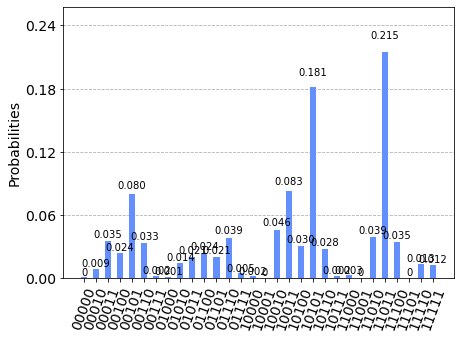

In [11]:
# Create a simulator
simulator = QasmSimulator()
# Compile the circuit for the simulator
compiled_circuit = transpile(phase_estimation_circuit, simulator)
# Simulate the circuit 2048 times
simulation = simulator.run(compiled_circuit, shots=2048)
# Get the simulation results
simulation_result = simulation.result()
counts = simulation_result.get_counts(compiled_circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

The above histogram shows the number of times we obtained each measurement result. The entries on the horizontal axis are bit strings representing readings of $\vert\hat\psi\rangle$. We may convert these bit strings to decimal form which gives us $\hat\psi$ as a real decimal number. Finally, we use $\lambda = e^{2i\pi\psi}$ to get the eigenvalue estimate. As mentioned, the circuit is more likely to output values for which $\vert c_{v}\vert = \langle 0...0\vert v\rangle$ is largest. Having run the circuit 2048 times, we can see that two values appear more frequently than the others. This suggests we are likely to have found at least two eigenvalues. The other two eigenvalues that we are looking for may have a low probability of getting measured, so it is unclear whether the next two largest measured values are estimates for eigenvalues or not.

Nevertheless, we take the 4 most frequently occuring measurement results and calculate eigenvalues from them.

In [12]:
# Sort results from highest to lowest
results_sorted = sorted(counts, key = lambda x: abs(counts[x])**2, reverse=True)
# Get most common results
if v <= t:
    most_common_results = results_sorted[:2**v]
else:
    most_common_results = results_sorted[:2**t]

# Returns decimal representation of bit string (fraction)
def bin_to_dec(str):
    value = 0
    for i in range(len(str)):
        value += float(str[i]) * 2**(-1-i)
    return value

# Get eigenvalues in a + bi form.
eigenvalue_estimates = [np.round(np.exp(2j * np.pi * bin_to_dec(k)), 4) for i, k in enumerate(most_common_results)]
eigenvalue_estimates = set(eigenvalue_estimates)
eigenvalue_estimates

{(-0.8315-0.5556j), (-0.5556-0.8315j), (0.5556-0.8315j), (0.5556+0.8315j)}

Next we calculate eigenvalues using a classical algorithm.

In [13]:
from qiskit.quantum_info import Operator

# Get a numpy matrix representation of the unitary gate
U = np.array(Operator(random_unitary).data)
# Calculate the eigenvalues classically
true_eigenvalues, a = np.linalg.eig(U)
true_eigenvalues = [np.round(i, 4) for i in true_eigenvalues]
true_eigenvalues = set(true_eigenvalues)
true_eigenvalues

{(-0.6433+0.7656j), (-0.5654-0.8248j), (0.5922-0.8058j), (0.6178+0.7863j)}

The results are summarised in the table below.

| Estimated Eigenvalues | True Eigenvalues | delta Re | delta Im |
| --- | --- | --- | --- |
| -0.8315 - 0.5556i | -0.6433 + 0.7656i | 0.1882 | 1.3212 |
| -0.5556 - 0.8315i | -0.5654 - 0.8248i | 0.0098 | 0.0067 |
| 0.5556 - 0.8315i | 0.5922 - 0.8058i | 0.0366 | 0.0257 |
| 0.5556 + 0.8315i | 0.6178 + 0.7863i | 0.0622 | 0.0452 |

The first eigenvalue is clearly not accurately estimated. The next two eigenvalues are quite accurately estimated. We can see that the errors are quite low. The error on the final eigenvalue is considerably larger, so it is not as accurately estimated. 

We conclued that at between two and three eigenvalues have been accurately estimated, and a fourth eigenvalue has clearly not been accurately esimated. 

Note that we could now prepare a different starting state in the v qubits in the circuit, and the probabilities of measuring each eigenvalue would change. For instance, we could prepare the starting state $\vert0...1\rangle$ rather than $\vert0...0\rangle$ as we did initially. These two states are orthogonal, so it is likely that a different set of eigenvalues would come out as the most likely to be measured. Running the circuit several times with various starting states in v would thus provide us with more eigenvalue estimates, and we could eventually obtain all the eigenvalues accurately. 

We cannot run the circuit with more initial orthogonal states than there there are dimensions of the matrix. At this point we are likely to have obtained all eigenvalues with high accuracy. Hence, the running time of the entire experiment is expected to scale linearly with the number of dimensions of the matrix for which we are trying to estimate eigenvalues.